#XMAP plotter

##Helping hands

http://nbviewer.ipython.org/github/herrfz/dataanalysis/blob/master/week2/getting_data.ipynb

http://nbviewer.ipython.org/github/jvns/pandas-cookbook/blob/master/cookbook/Chapter%201%20-%20Reading%20from%20a%20CSV.ipynb


##Imports

In [172]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
#import matplotlib as plt
#plt.use('TkAgg') 

import operator
import re
from collections     import defaultdict

import pylab
pylab.show()

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


##Definitions

In [173]:
fileUrl = "../S_lycopersicum_chromosomes.2.50.BspQI_to_EXP_REFINEFINAL1_xmap.txt"
MIN_CONF = 10.0
FULL_FIG_W , FULL_FIG_H  = 16, 8
CHROM_FIG_W, CHROM_FIG_H = FULL_FIG_W, 20

##Setup

###Figure sizes controller

In [174]:
class size_controller(object):
    def __init__(self, w, h):
        self.w = w
        self.h = h
        
    def __enter__(self):
        self.o = rcParams['figure.figsize']
        rcParams['figure.figsize'] = self.w, self.h
        return None
    
    def __exit__(self, type, value, traceback):
        rcParams['figure.figsize'] = self.o

###Column type definition

In [175]:
col_type_int = np.int64
col_type_flo = np.float64
col_type_str = np.object
col_info =[
    [ "XmapEntryID" , col_type_int ],
    [ "QryContigID" , col_type_int ],
    [ "RefContigID" , col_type_int ],
    [ "QryStartPos" , col_type_flo ],
    [ "QryEndPos"   , col_type_flo ],
    [ "RefStartPos" , col_type_flo ],
    [ "RefEndPos"   , col_type_flo ],
    [ "Orientation" , col_type_str ],
    [ "Confidence"  , col_type_flo ],
    [ "HitEnum"     , col_type_str ],
    [ "QryLen"      , col_type_flo ],
    [ "RefLen"      , col_type_flo ],
    [ "LabelChannel", col_type_str ],
    [ "Alignment"   , col_type_str ],
]

col_names=[cf[0] for cf in col_info]
col_types=dict(zip([c[0] for c in col_info], [c[1] for c in col_info]))
col_types


{'Alignment': object,
 'Confidence': numpy.float64,
 'HitEnum': object,
 'LabelChannel': object,
 'Orientation': object,
 'QryContigID': numpy.int64,
 'QryEndPos': numpy.float64,
 'QryLen': numpy.float64,
 'QryStartPos': numpy.float64,
 'RefContigID': numpy.int64,
 'RefEndPos': numpy.float64,
 'RefLen': numpy.float64,
 'RefStartPos': numpy.float64,
 'XmapEntryID': numpy.int64}

##Read XMAP
http://nbviewer.ipython.org/github/herrfz/dataanalysis/blob/master/week2/getting_data.ipynb

In [176]:
CONVERTERS = {
    'info': filter_conv
}
SKIP_ROWS = 9
NROWS     = None
gffData = pd.read_csv(fileUrl, names=col_names, index_col='XmapEntryID', dtype=col_types, header=None, skiprows=SKIP_ROWS, delimiter="\t", comment="#", verbose=True, nrows=NROWS)
gffData.head()

Tokenization took: 8.72 ms
Type conversion took: 20.52 ms
Parser memory cleanup took: 0.01 ms


,QryContigID,RefContigID,QryStartPos,QryEndPos,RefStartPos,RefEndPos,Orientation,Confidence,HitEnum,QryLen,RefLen,LabelChannel,Alignment
XmapEntryID,,,,,,,,,,,,,
1,141,1,528400.6,571697.5,10672.0,54237.5,+,6.65,4M2D2M,1439123.5,21805821,1,"(1,34)(2,34)(3,35)(4,36)(5,37)(6,38)(8,38)(9,39)"
2,174,1,21236.5,1568390.0,10672.0,1553561.0,+,79.35,2M3D1M1D1M1D4M1I2M1D2M1D1M2I2D9M3I3M1D6M1D2M2D...,1568410.0,21805821,1,"(1,2)(2,2)(3,3)(6,4)(7,4)(9,5)(11,6)(12,7)(13,..."
3,1129,1,444677.7,340490.1,52972.0,154578.0,-,9.08,4M1D2M1D2M,650802.9,21805821,1,"(6,27)(8,27)(9,26)(10,25)(11,24)(13,23)(14,22)..."
4,42,1,1439722.2,1522476.2,54237.5,135860.0,+,7.53,6M1D1M,2153950.0,21805821,1,"(7,99)(9,99)(10,100)(11,101)(12,102)(13,103)(1..."
5,1752,1,210082.7,158973.4,55635.0,106448.0,-,6.59,5M,703838.0,21805821,1,"(10,15)(11,14)(12,13)(13,12)(14,11)"


###Add length column

In [177]:
gffData['qry_match_len'] = abs(gffData['QryEndPos'] - gffData['QryStartPos'])
gffData['ref_match_len'] = abs(gffData['RefEndPos'] - gffData['RefStartPos'])
gffData['match_prop'   ] = gffData['qry_match_len'] / gffData['ref_match_len']
gffData = gffData[gffData['Confidence'] >= MIN_CONF]
del gffData['LabelChannel']
gffData.head()

,QryContigID,RefContigID,QryStartPos,QryEndPos,RefStartPos,RefEndPos,Orientation,Confidence,HitEnum,QryLen,RefLen,Alignment,qry_match_len,ref_match_len,match_prop
XmapEntryID,,,,,,,,,,,,,,,
2,174,1,21236.5,1568390.0,10672,1553561,+,79.35,2M3D1M1D1M1D4M1I2M1D2M1D1M2I2D9M3I3M1D6M1D2M2D...,1568410.0,21805821,"(1,2)(2,2)(3,3)(6,4)(7,4)(9,5)(11,6)(12,7)(13,...",1547153.5,1542889,1.002764
32,430,1,20.0,651018.8,1493902,2123769,+,48.60,9M1D1M4D2M1I1D4M2D3M1I1D1M1D1M1I1D6M1D6M1D4M1D...,651038.8,21805821,"(161,1)(162,2)(163,3)(164,4)(165,5)(166,6)(167...",650998.8,629867,1.033550
49,877,1,185486.6,20.0,2289130,2470486,-,13.00,3M1I1D2M2D6M2D2M1I1D2M,803876.2,21805821,"(236,17)(237,16)(238,15)(240,13)(241,12)(244,1...",185466.6,181356,1.022666
53,563,1,614521.1,20.0,2470486,3076619,-,39.72,2M1I1D1M1I5M1D5M1D1M1D4M2D1M1D3M1D3M1D2M1D1M1D...,614541.2,21805821,"(256,43)(257,42)(259,40)(260,38)(261,37)(262,3...",614501.1,606133,1.013806
63,276,1,599215.1,211191.6,3450761,3837771,-,18.32,1M1I3M3D5M2D1M4D2M1D2M1I2D2M2D3M1D4M,1006781.1,21805821,"(335,47)(336,45)(337,44)(338,43)(342,42)(343,4...",388023.5,387010,1.002619


In [178]:
re_matches    = re.compile("(\d+)M")
re_insertions = re.compile("(\d+)I")
re_deletions  = re.compile("(\d+)D")
def process_cigar(cigar, **kwargs):
    """
    2M3D1M1D1M1D4M1I2M1D2M1D1M2I2D9M3I3M1D6M1D2M2D1M1D6M1D1M1D1M2D2M2D1M1I1D1M1D5M2D4M2D1M2D2M1D2M1D3M1D1M1D2M3I3D1M1D1M3D2M3D1M2I1D1M2D1M1D1M1I2D3M2I1M1D2M1D1M1D1M2I3D3M3D1M2D1M1D1M1D5M2D12M
    """
    assert(set([x for x in cigar]) <= set(['M', 'D', 'I', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']))

    cigar_matches    = 0
    cigar_insertions = 0
    cigar_deletions  = 0

    i_matches = re_matches   .finditer(cigar)
    i_inserts = re_insertions.finditer(cigar)
    i_deletes = re_deletions .finditer(cigar)

    for i in i_matches:
        n                 = i.group(1)
        cigar_matches    += int(n)

    for i in i_inserts:
        n                 = i.group(1)
        cigar_insertions += int(n)

    for i in i_deletes:
        n                 = i.group(1)
        cigar_deletions  += int(n)

    return cigar_matches, cigar_insertions, cigar_deletions

gffData[['cigar_matches', 'cigar_insertions', 'cigar_deletions']] = gffData['HitEnum'].apply(process_cigar, axis=1).apply(pd.Series, 1)
del gffData['HitEnum']

gffData.head()


,QryContigID,RefContigID,QryStartPos,QryEndPos,RefStartPos,RefEndPos,Orientation,Confidence,QryLen,RefLen,Alignment,qry_match_len,ref_match_len,match_prop,cigar_matches,cigar_insertions,cigar_deletions
XmapEntryID,,,,,,,,,,,,,,,,,
2,174,1,21236.5,1568390.0,10672,1553561,+,79.35,1568410.0,21805821,"(1,2)(2,2)(3,3)(6,4)(7,4)(9,5)(11,6)(12,7)(13,...",1547153.5,1542889,1.002764,105,17,63
32,430,1,20.0,651018.8,1493902,2123769,+,48.60,651038.8,21805821,"(161,1)(162,2)(163,3)(164,4)(165,5)(166,6)(167...",650998.8,629867,1.033550,52,4,15
49,877,1,185486.6,20.0,2289130,2470486,-,13.00,803876.2,21805821,"(236,17)(237,16)(238,15)(240,13)(241,12)(244,1...",185466.6,181356,1.022666,15,2,6
53,563,1,614521.1,20.0,2470486,3076619,-,39.72,614541.2,21805821,"(256,43)(257,42)(259,40)(260,38)(261,37)(262,3...",614501.1,606133,1.013806,41,2,19
63,276,1,599215.1,211191.6,3450761,3837771,-,18.32,1006781.1,21805821,"(335,47)(336,45)(337,44)(338,43)(342,42)(343,4...",388023.5,387010,1.002619,23,2,15


In [179]:
re_alignment  = re.compile("\((\d+),(\d+)\)")

def process_alignment(alignment, **kwargs):
    """
     Alignment (4862,48)(4863,48)(4864,47)(4865,46)(4866,45)(4867,44)(4870,43)(4873,42)(4874,41)(4875,40)(4877,40)(4878,39)(4879,38)(4880,37)(4883,36)(4884,36)(4885,35)(4886,34)(4887,33)(4888,33)(4889,32)(4890,30)(4891,30)(4892,29)(4893,28)(4894,28)(4899,27)(4900,26)(4901,25)(4902,24)(4903,23)(4904,22)(4906,21)(4907,21)(4908,20)(4910,19)(4911,18)(4912,17)(4913,16)(4915,15)(4917,14)(4918,13)(4919,12)(4920,11)(4922,10)(4923,9)(4925,8)(4927,7)(4930,6)(4931,5)(4932,3)(4933,2)(4934,1)
    """
    assert(set([x for x in alignment]) <= set(['(', ')', ',', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9']))

    count_refs             = defaultdict(int)
    count_queries          = defaultdict(int)
    count_refs_colapses    = 0
    count_queries_colapses = 0

    i_alignment = re_alignment.finditer(alignment)
    for i in i_alignment:
        c_r           = int(i.group(1))
        c_q           = int(i.group(2))

        count_refs   [c_r] += 1
        count_queries[c_q] += 1

    count_refs_colapses    = sum([count_refs[   x] for x in count_refs    if count_refs[   x] > 1])
    count_queries_colapses = sum([count_queries[x] for x in count_queries if count_queries[x] > 1])

    return len(count_refs), len(count_queries), count_refs_colapses, count_queries_colapses

gffData[['len_count_refs', 'len_count_queries', 'count_refs_colapses', 'count_queries_colapses']] = gffData['Alignment'].apply(process_alignment, axis=1).apply(pd.Series, 1)
del gffData['Alignment']
gffData.head()



,QryContigID,RefContigID,QryStartPos,QryEndPos,RefStartPos,RefEndPos,Orientation,Confidence,QryLen,RefLen,qry_match_len,ref_match_len,match_prop,cigar_matches,cigar_insertions,cigar_deletions,len_count_refs,len_count_queries,count_refs_colapses,count_queries_colapses
XmapEntryID,,,,,,,,,,,,,,,,,,,,
2,174,1,21236.5,1568390.0,10672,1553561,+,79.35,1568410.0,21805821,1547153.5,1542889,1.002764,105,17,63,119,105,0,28
32,430,1,20.0,651018.8,1493902,2123769,+,48.60,651038.8,21805821,650998.8,629867,1.033550,52,4,15,54,52,0,4
49,877,1,185486.6,20.0,2289130,2470486,-,13.00,803876.2,21805821,185466.6,181356,1.022666,15,2,6,16,15,0,2
53,563,1,614521.1,20.0,2470486,3076619,-,39.72,614541.2,21805821,614501.1,606133,1.013806,41,2,19,45,41,0,8
63,276,1,599215.1,211191.6,3450761,3837771,-,18.32,1006781.1,21805821,388023.5,387010,1.002619,23,2,15,26,23,0,6


##More stats

In [180]:
ref_qry           = gffData[['RefContigID','QryContigID']]
ref_qry           = ref_qry.sort('RefContigID')
print ref_qry.head()

ref_qry_grpby_ref = ref_qry.groupby('RefContigID', sort=True)
ref_qry_grpby_ref.head()

             RefContigID  QryContigID
XmapEntryID                          
2                      1          174
168                    1          308
122                    1          165
114                    1           41
104                    1          473


RefContigID  QryContigID
RefContigID XmapEntryID                          
1           2                      1          174
            168                    1          308
            122                    1          165
            114                    1           41
            104                    1          473
2           665                    2          670
            714                    2         1008
            705                    2          539
            695                    2          283
            694                    2         1303
3           1222                   3          812
            1202                   3           77
            1196                   3          340
            1191                   3          301
            1184                   3          261
4           1686                   4           21
            1661                   4          517
            1684                   4          504
            1682                   4          554
            1669                   4          139
5           2185                   5          238
            2191                   5          970
            2201                   5          900
            2179                   5         1362
            2195                   5          406
6           2740                   6          969
            2722                   6         1190
            2735                   6         1101
            2733                   6         1325
            2730                   6         1154
7           3138                   7         1167
            3125                   7          482
            3123                   7           49
            3092                   7         1254
            3093                   7          548
8           3641                   8          728
            3596                   8         1300
            3637                   8          881
            3633                   8         1031
            3626                   8          584
9           4158                   9          306
            4155                   9          576
            4147                   9          417
            4140                   9         2566
            4134                   9          867
10          4616                  10          240
            4579                  10          234
            4609                  10          398
            4603                  10          388
            4599                  10          586
11          5204                  11          163
            5183                  11         1308
            5178                  11          404
            5175                  11         1019
            5173                  11          985
12          5652                  12          438
            5584                  12           89
            5600                  12          171
            5603                  12          745
            5613                  12          893
13          6178                  13          965
            6150                  13          623
            6168                  13          344
            6160                  13          253
            6154                  13         1977

In [181]:
qry_ref           = gffData[['QryContigID','RefContigID']]
qry_ref           = qry_ref.sort('QryContigID')
print qry_ref.head()

qry_ref_grpby_qry = qry_ref.groupby('QryContigID', sort=True)
qry_ref_grpby_qry.head()

             QryContigID  RefContigID
XmapEntryID                          
1467                   1            4
4003                   1            9
2920                   2            7
552                    2            2
937                    2            3


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 806 entries, (1, 1467) to (2770, 854)
Data columns:
QryContigID    806  non-null values
RefContigID    806  non-null values
dtypes: int64(2)

In [182]:
def stats_from_data_vals(RefContigID, QryContigID, groups, indexer, data, data_vals, valid_data_poses):
    ref_lens             = [ ( x["RefStartPos"], x["RefEndPos"] ) for x in data_vals ]
    qry_lens             = [ ( x["QryStartPos"], x["QryEndPos"] ) for x in data_vals ]

    num_qry_matches = []
    for RefContigID_l in groups["QryContigID_RefContigID"][QryContigID]:
        for match_pos in groups["QryContigID_RefContigID"][QryContigID][RefContigID_l]:
            if match_pos in valid_data_poses:
                num_qry_matches.append(RefContigID_l)

    #num_qry_matches      = len( groups["QryContigID_RefContigID"][QryContigID] )
    num_qry_matches      = len( set(num_qry_matches)                       )
    num_orientations     = len( set([x["Orientation"] for x in data_vals]) )

    ref_no_gap_len       = sum( [ max(x)-min(x) for x in ref_lens ] )
    ref_min_coord        = min( [ min(x)        for x in ref_lens ] )
    ref_max_coord        = max( [ max(x)        for x in ref_lens ] )
    ref_gap_len          = ref_max_coord - ref_min_coord

    qry_no_gap_len       = sum( [ max(x)-min(x) for x in qry_lens ] )
    qry_min_coord        = min( [ min(x)        for x in qry_lens ] )
    qry_max_coord        = max( [ max(x)        for x in qry_lens ] )
    qry_gap_len          = qry_max_coord - qry_min_coord

    XmapEntryIDs         = groups["QryContigID_XmapEntryID"][QryContigID].keys()

    Confidences          = []
    for XmapEntryID in XmapEntryIDs:
        data_pos = list(indexer["XmapEntryID"][XmapEntryID])[0]
        if data_pos not in valid_data_poses:
            continue
        Confidences.append( [ data[data_pos]["Confidence"], data[data_pos]["RefContigID"] ] )

    max_confidence       = max([ x[0] for x in Confidences ])
    max_confidence_chrom = [ x[1] for x in Confidences if x[0] == max_confidence][0]

    stats = {}
    stats["_meta_is_max_confidence_for_qry_chrom"      ] = max_confidence_chrom == RefContigID

    stats["_meta_len_ref_match_gapped"                 ] = ref_gap_len
    stats["_meta_len_ref_match_no_gap"                 ] = ref_no_gap_len
    stats["_meta_len_qry_match_gapped"                 ] = qry_gap_len
    stats["_meta_len_qry_match_no_gap"                 ] = qry_no_gap_len

    stats["_meta_max_confidence_for_qry"               ] = max_confidence
    stats["_meta_max_confidence_for_qry_chrom"         ] = max_confidence_chrom

    stats["_meta_num_orientations"                     ] = num_orientations
    stats["_meta_num_qry_matches"                      ] = num_qry_matches
    stats["_meta_qry_matches"                          ] = ','.join( [ str(x) for x in sorted(list(set([ x[1] for x in Confidences ]))) ] )

    stats["_meta_proportion_sizes_gapped"              ] = (ref_gap_len    * 1.0)/ qry_gap_len
    stats["_meta_proportion_sizes_no_gap"              ] = (ref_no_gap_len * 1.0)/ qry_no_gap_len

    return stats


In [183]:
for QryContigID in sorted(QryContigIDs):
    data_poses           = list(groups["RefContigID_QryContigID"][RefContigID][QryContigID])
    all_data_poses       = list(indexer["QryContigID"][QryContigID])
    data_vals            = [ data[x] for x in data_poses ]

    stats                = stats_from_data_vals(RefContigID, QryContigID, groups, indexer, data, data_vals, all_data_poses)

    #print "RefContigID %4d QryContigID %6d" % ( RefContigID, QryContigID )
    for data_val in data_vals:
        cigar                = data_val["HitEnum"]
        cigar_matches, cigar_insertions, cigar_deletions = process_cigar(cigar)

        Alignment            = data_val["Alignment"]
        alignment_count_queries, alignment_count_refs, alignment_count_refs_colapses, alignment_count_queries_colapses = process_alignment(Alignment)

        for stat in stats:
            data_val[stat] = stats[stat]


        data_val["_meta_proportion_query_len_gapped"          ] = (data_val['_meta_len_qry_match_gapped'] * 1.0)/ data_val["QryLen"]
        data_val["_meta_proportion_query_len_no_gap"          ] = (data_val['_meta_len_qry_match_no_gap'] * 1.0)/ data_val["QryLen"]

        #print " ", " ".join( ["%s %s" % (x, str(data_val[x])) for x in sorted(data_val)] )
        reporter.write(            "\t".join( [ str(data_val[x])                                   for x in valid_fields['names'  ] ] ) + "\n"  )


NameError: name 'QryContigIDs' is not defined

##Good part

http://nbviewer.ipython.org/github/jvns/pandas-cookbook/blob/master/cookbook/Chapter%201%20-%20Reading%20from%20a%20CSV.ipynb

http://pandas.pydata.org/pandas-docs/dev/visualization.html

https://bespokeblog.wordpress.com/2011/07/11/basic-data-plotting-with-matplotlib-part-3-histograms/

http://nbviewer.ipython.org/github/mwaskom/seaborn/blob/master/examples/plotting_distributions.ipynb

http://nbviewer.ipython.org/github/herrfz/dataanalysis/blob/master/week3/exploratory_graphs.ipynb

http://pandas.pydata.org/pandas-docs/version/0.15.0/visualization.html

http://www.gregreda.com/2013/10/26/working-with-pandas-dataframes/

###Column types

In [ ]:
gffData.dtypes

###Global statistics

In [ ]:
gffData[['Confidence', 'QryLen', 'qry_match_len', 'ref_match_len', 'match_prop']].describe()

###List of chromosomes

In [ ]:
chromosomes = np.unique(gffData['RefContigID'].values)
chromosomes

###Quality distribution

In [ ]:
with size_controller(FULL_FIG_W, FULL_FIG_H):
    bq = gffData.boxplot(column='Confidence')

###Quality distribution per chromosome

In [ ]:
with size_controller(FULL_FIG_W, FULL_FIG_H):
    bqc = gffData.boxplot(column='Confidence', by='RefContigID')

###Position distribution

In [ ]:
with size_controller(FULL_FIG_W, FULL_FIG_H):
    hs = gffData['RefStartPos'].hist()

###Position distribution per chromosome

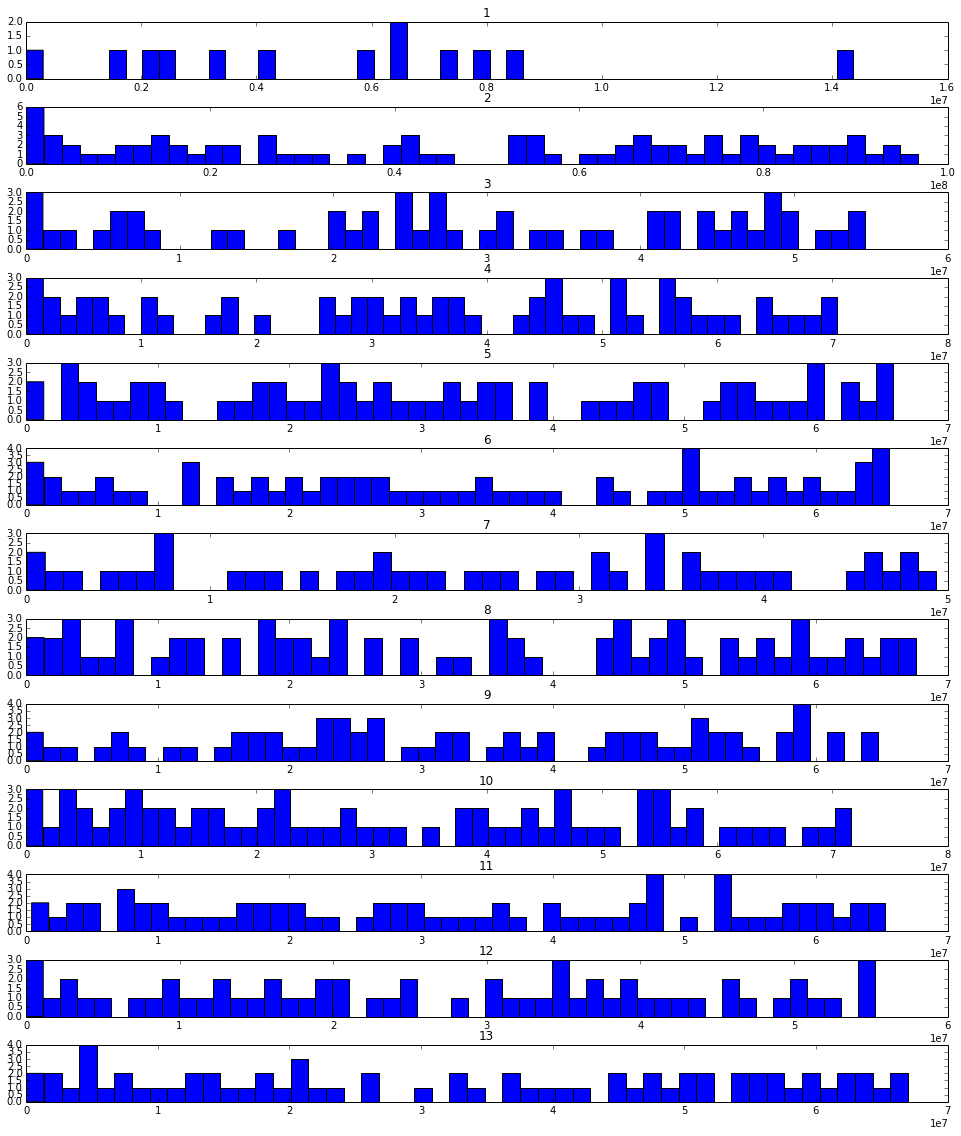

In [45]:
hsc = gffData['qry_match_len'].hist(by=gffData['RefContigID'], figsize=(CHROM_FIG_W, CHROM_FIG_H), layout=(len(chromosomes),1)) 

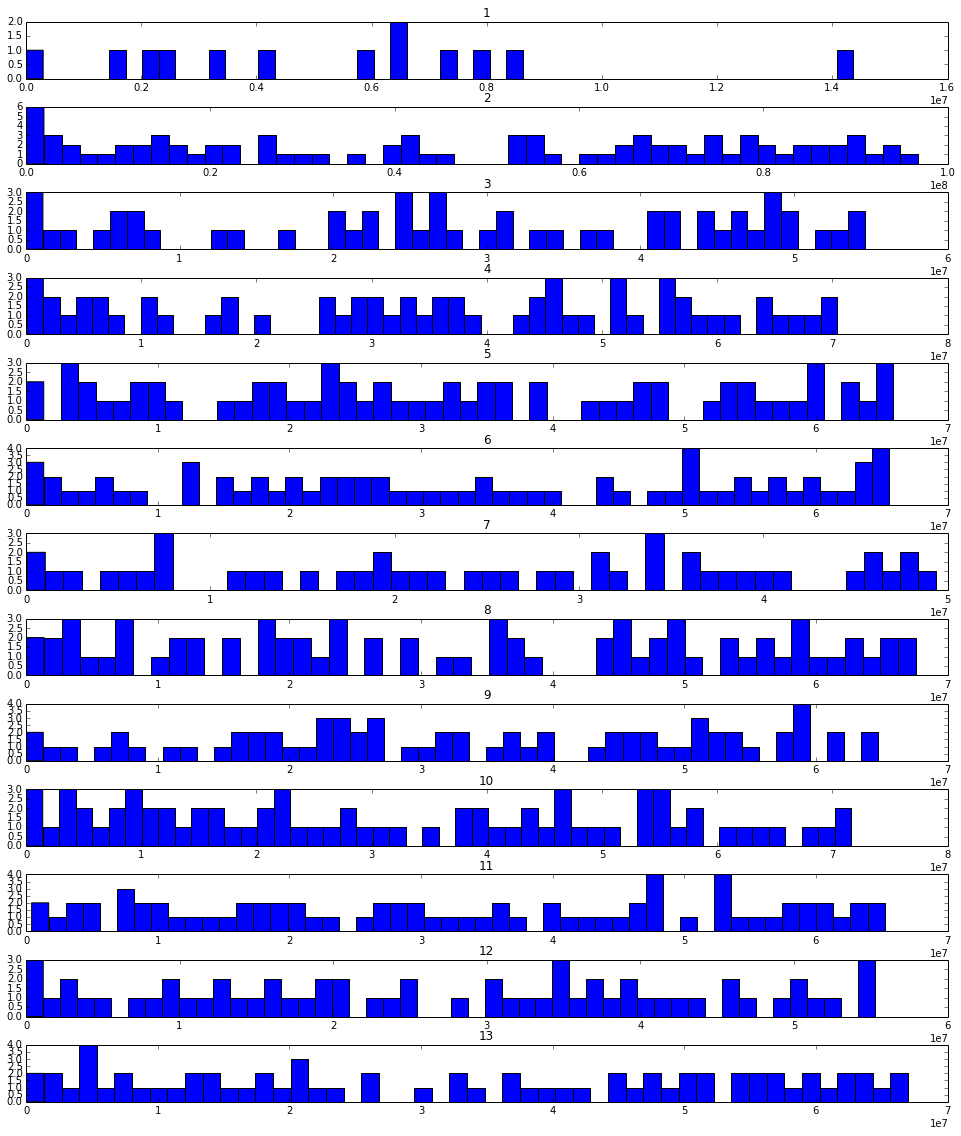

In [45]:
hsc = gffData['RefStartPos'].hist(by=gffData['RefContigID'], figsize=(CHROM_FIG_W, CHROM_FIG_H), layout=(len(chromosomes),1)) 

###Length distribution

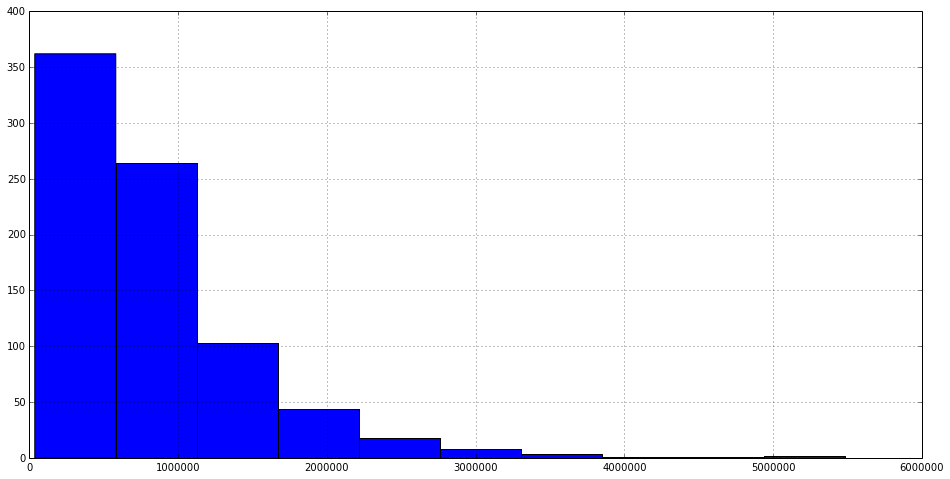

In [46]:
with size_controller(FULL_FIG_W, FULL_FIG_H):
    hl = gffData['qry_match_len'].hist()

###Length distribution per chromosome

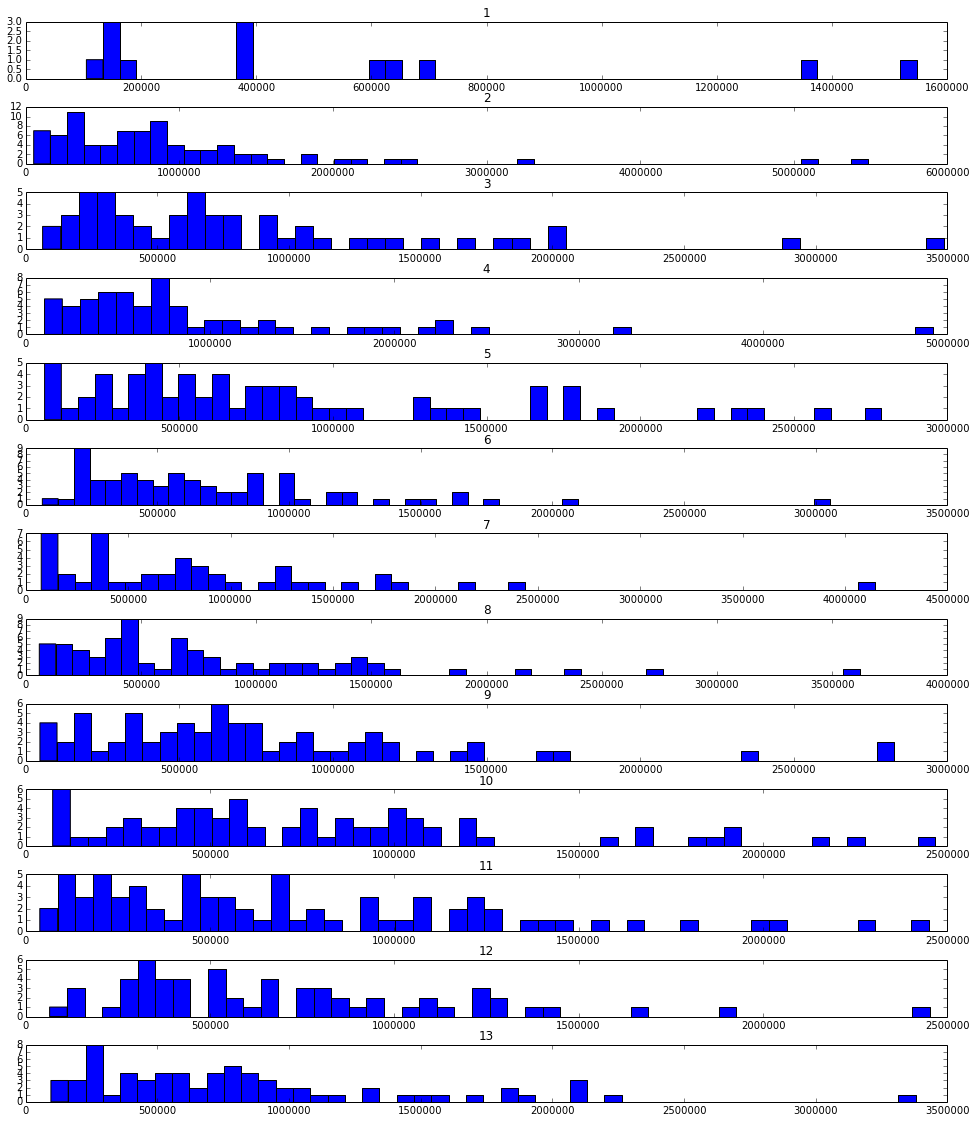

In [47]:
hlc = gffData['qry_match_len'].hist(by=gffData['RefContigID'], figsize=(CHROM_FIG_W, CHROM_FIG_H), layout=(len(chromosomes),1))